In [1]:
!pip install easyocr pytesseract opencv-python Pillow numpy
!apt-get update
!apt-get install tesseract-ocr

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 50.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 180.7/180.7 kB 18.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 963.8/963.8 kB 46.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 292.1/292.1 kB 29.2 MB/s eta 0:00:00
Hit:1 https://cli.github.com/packages stable InRelease
Get:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,628 B]
Get:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:5 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:6 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ Packages [81.0 kB]
Get:7 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:8 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [2,014 kB]
Get:9 http://archive.ubuntu.com/ubuntu jammy-updates I

In [2]:
#Import datasets
import kagglehub

# Download latest version
path = kagglehub.dataset_download("topkek69/vietnamese-license-plate-ocr")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'vietnamese-license-plate-ocr' dataset.
Path to dataset files: /kaggle/input/vietnamese-license-plate-ocr


In [3]:
from PIL import Image
import easyocr
import pytesseract
import cv2
import numpy as np
from typing import List, Dict, Optional

In [19]:
from PIL import Image
import easyocr
import pytesseract
import cv2
import numpy as np
from typing import List, Dict, Optional

class LicensePlateOCR:
    def __init__(self, ocr_engine = 'easyocr'):
        self.ocr_engine = ocr_engine
        if ocr_engine == 'easyocr':
            self.reader = easyocr.Reader(['vi','en'])

    def preprocess_plate(self, plate_image):
        # Read image
        img = cv2.imread(image_path)

        # Resize if too small
        height, width = img.shape[:2]
        if height < 100 or width < 200:
          scale = max(100/height, 200/width)
          img = cv2.resize(img, None, fx=scale, fy=scale,
                          interpolation=cv2.INTER_CUBIC)

        # Convert to grayscale
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Enhance contrast
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
        enhanced = clahe.apply(gray)

        # Denoise
        denoised = cv2.bilateralFilter(enhanced, 9, 75, 75)

        # Threshold
        binary = cv2.adaptiveThreshold(denoised, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                    cv2.THRESH_BINARY, 11, 2)

        # Clean up
        kernel = np.ones((2,2), np.uint8)
        cleaned = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel)

        return cleaned

    def extract_text_easyOCR(self, plate_image):
        """Extract text using EasyOCR"""
        results = self.reader.readtext(plate_image)
        # Check confidence score, filter, and combine results
        text_results = []
        for (bbox, text, confidence) in results:
            if confidence > 0.6: #Set threshold to 0.6
                text_results.append(text)
        return ' '.join(text_results)

    def extract_text_tesseract(self, plate_image):
        """Extract text using Tesseract"""
        # Convert to PIL Image
        pil_image = Image.fromarray(cv2.cvtColor(plate_image, cv2.COLOR_BGR2RGB))

        # Custom config for license plates
        custom_config = r'--oem 3 --psm 8 -c tessedit_char_whitelist=ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789'

        text = pytesseract.image_to_string(pil_image, config=custom_config)
        return text.strip()

    def recognize_plate(self, plate_image):
        """Main method to recognize license plate text"""
        # Preprocess the image
        processed_image = self.preprocess_plate(plate_image)

        if self.ocr_engine == 'easyocr':
            return self.extract_text_easyOCR(processed_image)
        else:
            return self.extract_text_tesseract(processed_image)

In [5]:
import os

def test_ocr_engine():
    # Initialize OCR engine
    ocr = LicensePlateOCR(ocr_engine='easyocr')

    # Test with sample images
    test_images_path = path

    for image_file in os.listdir(test_images_path):
        if image_file.lower().endswith(('.png', '.jpg', '.jpeg')):
            # Load image
            image_path = os.path.join(test_images_path, image_file)
            plate_image = cv2.imread(image_path)

            if plate_image is not None:
                # Recognize text
                result = ocr.recognize_plate(plate_image)
                print(f"Image: {image_file} -> Text: '{result}'")

if __name__ == "__main__":
    test_ocr_engine()

Progress: |██████████████████████████████████████████████████| 100.0% Complete

Progress: |██████████████████████████████████████████████████| 100.0% Complete

In [6]:
import os
import json

class DatasetProcessor:
    def __init__(self, dataset_path: str):
        self.dataset_path = dataset_path
        self.ocr = LicensePlateOCR(ocr_engine='easyocr')

    def process_dataset(self) -> List[Dict]:
        """Process entire dataset and return results"""
        results = []

        for image_file in os.listdir(self.dataset_path):
            if image_file.lower().endswith(('.png', '.jpg', '.jpeg')):
                image_path = os.path.join(self.dataset_path, image_file)
                plate_image = cv2.imread(image_path)

                if plate_image is not None:
                    recognized_text = self.ocr.recognize_plate(plate_image)

                    result = {
                        'image_filename': image_file,
                        'recognized_text': recognized_text,
                        'characters': list(recognized_text.replace(' ', ''))
                    }
                    results.append(result)
                    print(f"Processed: {image_file} -> {recognized_text}")

        return results

# Usage
if __name__ == "__main__":
    processor = DatasetProcessor(path)
    results = processor.process_dataset()
    print(f"Processed {len(results)} images")

Processed 0 images


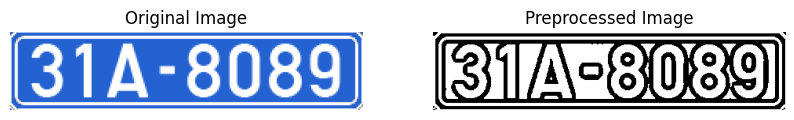

Recognized text: ''


In [25]:
#Main function
import cv2
import matplotlib.pyplot as plt
import os

# Initialize OCR
ocr = LicensePlateOCR(ocr_engine='easyocr')

new_path = '/kaggle/input/vietnamese-license-plate-ocr/generated'
# Test with the first image from the Kaggle dataset
test_files = [f for f in os.listdir(new_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

if test_files:
    # Load first image
    first_image = test_files[1]
    image_path = os.path.join(new_path, first_image)
    plate_image = cv2.imread(image_path)

    # Display original image
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(plate_image, cv2.COLOR_BGR2RGB))
    plt.title('Original Image')
    plt.axis('off')

    # Show preprocessed image
    processed = ocr.preprocess_plate(plate_image)
    plt.subplot(1, 2, 2)
    plt.imshow(processed, cmap='gray')
    plt.title('Preprocessed Image')
    plt.axis('off')
    plt.show()

    # Recognize text
    result = ocr.recognize_plate(plate_image)
    print(f"Recognized text: '{result}'")
else:
    print("No images found in the dataset.")

In [8]:
import os

# List the contents of the downloaded dataset directory
print(os.listdir(path))

['labels', 'cropped', 'generated']
